# Calculate statistics and visualize results

In [2]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib as mpl
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
mpl.rcParams['svg.fonttype'] = 'none' # Takes care that texts show up when 
# importing pdf-plots into Inkcape

from src.data import var_names
from src.definitions import REPO_ROOT, PROCESSED_DATA_DIR, RAW_DATA_DIR, RESULTS_DIR

## Make ROC AUC violinplots

In [3]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib as mpl
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
mpl.rcParams['svg.fonttype'] = 'none' # Takes care that texts show up when 
# importing pdf-plots into Inkcape

import src.data.var_names as var_names
from src.definitions import REPO_ROOT, PROCESSED_DATA_DIR, RAW_DATA_DIR

In [4]:
%load_ext autoreload
%autoreload 2
from src.visualization.viz import (
    load_test_auc_data, load_test_auc_unadjusted_data, auc_violinplot, permutation_test
)

Load mean AUCs on unpermuted and permuted datasets.

In [5]:
mean_unpermuted_aucs, permuted_aucs_values, unpermuted_aucs_values = load_test_auc_data(
    methods=[
        'xgboost_cce', 'logistic_regression_cce', 'logistic_regression_ovr'
    ],
    segmentation="sri"
)

In [6]:
# Apply Bonferroni correction to original alpha of 0.05. We are performing
# 16 permutation tests.
alpha=0.05 / 16

permuted_aucs=permuted_aucs_values
unpermuted_aucs=mean_unpermuted_aucs
methods_to_plot=['xgboost_cce', 'logistic_regression_ovr']
xlims=(0.375, 0.675)
alpha=alpha

Load unadjusted

In [7]:
methods = ['logistic_regression_ovr', 'xgboost_cce']

mean_unperm_unadj_aucs, unperm_unadj_aucs = load_test_auc_unadjusted_data(
    methods, segmentation="sri"
)

Plot as violinplots.

/home/sebastian/miniconda3/envs/abcd/lib/python3.8/site-packages/pandas/core/indexing.py:1719: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


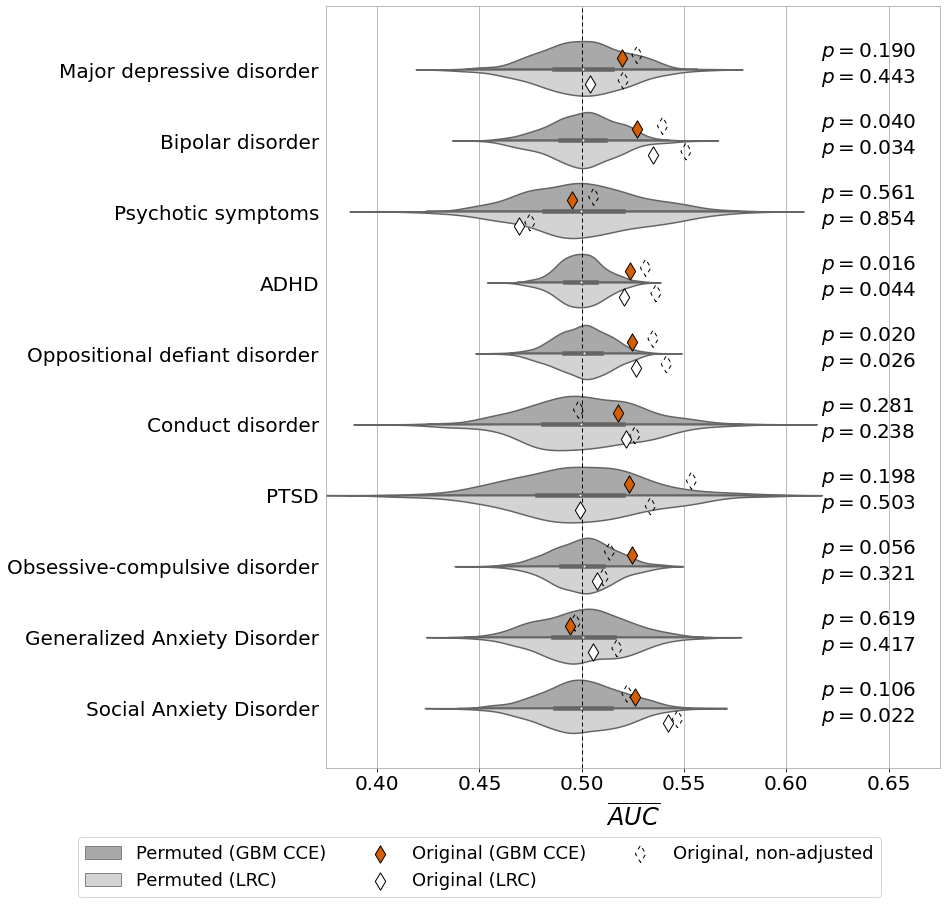

In [8]:
from typing import Tuple
from src.definitions import okabe_ito_palette

"""Displays and returns violinplot of ROC AUC values

Args:
    permuted_aucs: AUC values of predictions on permuted datasets (generated
        by 'load_test_auc_data')
    unpermuted_aucs: AUC values of predictions on original dataset
        (generated by 'load_test_auc_data')
    methods_to_plot: List of exactly two methods that should be plotted.
        Methods must occur in permuted_aucs['Method'] and be a key in
        permuted_aucs.
    xlims: Range of AUC values to plot
    alpha: Significance level alpha. p-values will be printed bold when they
        are below this number.

Returns:
    Violin plot
"""

if len(methods_to_plot) != 2:
    raise ValueError('methods_to_plot must contain exactly two elements!')

# Change labels for legend annotations
new_labels = {
    'logistic_regression_ovr': 'LRC',
    'logistic_regression_cce': 'LR CCE',
    'xgboost_cce': 'GBM CCE',
}
_permuted_aucs = permuted_aucs[
    permuted_aucs['Method'].isin(methods_to_plot)
]
for old, short in new_labels.items():
    _permuted_aucs.loc[
        _permuted_aucs['Method'] == old, 'Method'
    ] = f'Permuted ({short})'
colors = ['darkgrey', 'lightgrey']
colors_bars = [okabe_ito_palette['vermillion'], 'white']

# Plot violinplots of permuted dataset AUCs
fig = plt.figure(figsize=(11, 14))
#sns.set_style(style='whitegrid')
ax = sns.violinplot(
    y='Diagnosis',
    x='mean_auc',
    hue='Method',
    data=_permuted_aucs,
    palette=colors,
    whis=4,
    orient='h',
    hue_order=[f'Permuted ({new_labels[m]})' for m in methods_to_plot],
    zorder=1,
    split=True
)

# Plot adjustments
# Style
ax_color = 'darkgray'
ax.spines['bottom'].set_color(ax_color)
ax.spines['top'].set_color(ax_color)
ax.spines['right'].set_color(ax_color)
ax.spines['left'].set_color(ax_color)
ax.set_axisbelow(True)
ax.grid(color=ax_color, axis='x')
ax.set_xlim(xlims)
ax.set_xlabel('$\\overline{AUC}$', fontsize=24, labelpad=10)  # '$\\overline{AUC}$'
ax.set_ylabel('')
ax.set_yticklabels([
    'Major depressive disorder',
    'Bipolar disorder',
    'Psychotic symptoms',
    'ADHD',
    'Oppositional defiant disorder',
    'Conduct disorder',
    'PTSD',
    'Obsessive-compulsive disorder',
    'Generalized Anxiety Disorder',
    'Social Anxiety Disorder',
])
ax.tick_params(labelsize=20, left=False)
ax.axvline(
    x=0.5, linestyle=(0, (4, 3)), linewidth=1, color='black', zorder=1.5
)
y_offset = 0.18
markersize = 150
marker = 'd'

# Plot AUCs of original datasets
for i, diagnosis in enumerate(permuted_aucs['Diagnosis'].unique()):
    for j, method in enumerate(methods_to_plot):
        plt.scatter(
            x=unpermuted_aucs[method][diagnosis],
            y=i - y_offset + j * 2 * y_offset + 0.025,
            facecolors=colors_bars[j],
            edgecolors='black',
            alpha=1,
            marker=marker,
            s=markersize,
            zorder=2,
            label=f'Original ({new_labels[method]})' if i == 0 else None
        )
for i, diagnosis in enumerate(permuted_aucs['Diagnosis'].unique()):
    for j, method in enumerate(methods_to_plot):
        plt.scatter(
            x=mean_unperm_unadj_aucs[method][diagnosis],
            y=i - y_offset + j * 2 * y_offset - 0.025,
            facecolors='None',
            edgecolors='black',
            linestyle=(3, (4, 4)),
            alpha=1,
            marker=marker,
            s=markersize,
            zorder=1,
            label=f'Original, non-adjusted' if i == 0 and j == 0 else None
        )

#Show p-values
def mark_significance(p_val: float) -> Tuple[str, str]:
    if p_val <= alpha:
        str1 = '\\pmb{{'
        str2 = '}}'
    else:
        str1 = str2 = ''
    return str1, str2

p_values = permutation_test(permuted_aucs, unpermuted_aucs)
for i, diagnosis in enumerate(permuted_aucs['Diagnosis'].unique()):
    for j, method in enumerate(methods_to_plot):
        plt.annotate(
            text=f'$p = {p_values[method][diagnosis]:.3f}$',
            #text=f'$p = {str1}{p_values[method][diagnosis]:.3f}{str2}$',
            xy=(0.617, i - y_offset + j * 2 * y_offset),
            size=20
        )

ax.legend(loc='upper center', bbox_to_anchor=(0.25, -0.08), fontsize=18, ncol=3)
plt.show()

fig.savefig(
    REPO_ROOT / 'reports' / 'figures' / 'violinplot_sri.pdf',
    bbox_inches='tight',
    dpi=300
)

## Show mean and range of AUCs on original dataset

In [9]:
data_frames = []

for method, dic in unpermuted_aucs_values.items():
    aucs = pd.DataFrame(dic)
    summary = pd.DataFrame({
        "mean": aucs.mean(),
        "min": aucs.min(),
        "max": aucs.max(),
    })
    summary.columns = pd.MultiIndex.from_product([(method,), summary.columns])

    data_frames.append(summary)

pd.concat(data_frames, axis=1).round(3)

xgboost_cce                \
                                     mean    min    max   
Major Depressive Disorder           0.520  0.436  0.595   
Bipolar Disorder                    0.527  0.447  0.607   
Psychotic Symptoms                  0.495  0.394  0.595   
ADHD                                0.524  0.483  0.570   
Oppositional Defiant Disorder       0.525  0.436  0.569   
Conduct Disorder                    0.518  0.420  0.613   
PTSD                                0.523  0.361  0.645   
Obsessive Compulsive Disorder       0.524  0.463  0.578   
Generalized Anxiety Disorder        0.494  0.413  0.592   
Social Anxiety Disorder             0.526  0.437  0.622   

                              logistic_regression_cce                \
                                                 mean    min    max   
Major Depressive Disorder                       0.520  0.436  0.590   
Bipolar Disorder                                0.541  0.479  0.600   
Psychotic Symptoms                              0.504  0.405  0.627   
ADHD                                            0.518  0.475  0.561   
Oppositional Defiant Disorder                   0.527  0.479  0.568   
Conduct Disorder                                0.539  0.431  0.639   
PTSD                                            0.509  0.388  0.623   
Obsessive Compulsive Disorder                   0.513  0.459  0.575   
Generalized Anxiety Disorder                    0.521  0.449  0.627   
Social Anxiety Disorder                         0.537  0.469  0.634   

                              logistic_regression_ovr                
                                                 mean    min    max  
Major Depressive Disorder                       0.504  0.428  0.582  
Bipolar Disorder                                0.535  0.446  0.622  
Psychotic Symptoms                              0.470  0.355  0.572  
ADHD                                            0.521  0.473  0.573  
Oppositional Defiant Disorder                   0.526  0.485  0.571  
Conduct Disorder                                0.522  0.426  0.642  
PTSD                                            0.499  0.391  0.643  
Obsessive Compulsive Disorder                   0.507  0.436  0.555  
Generalized Anxiety Disorder                    0.506  0.432  0.567  
Social Anxiety Disorder                         0.542  0.472  0.618

## Show difference in mean adjusted - unadjusted

In [10]:
methods_selected = list(mean_unperm_unadj_aucs.keys())

auc_unadj = pd.DataFrame(mean_unperm_unadj_aucs).loc[:, methods_selected]
auc_unadj.columns = pd.MultiIndex.from_product([("unadjusted",), auc_unadj.columns])

auc_adj = pd.DataFrame(mean_unpermuted_aucs).loc[:, methods_selected]
auc_adj.columns = pd.MultiIndex.from_product([("adjusted",), auc_adj.columns])

auc_diff = auc_unadj.xs("unadjusted", axis=1) - auc_adj.xs("adjusted", axis=1)
auc_diff.columns = pd.MultiIndex.from_product([("unadjusted - adjusted",), auc_diff.columns])

auc_compare = pd.concat((auc_diff, auc_adj, auc_unadj), axis=1)

auc_compare.round(3)

unadjusted - adjusted              \
                              logistic_regression_ovr xgboost_cce   
Major Depressive Disorder                       0.016       0.007   
Bipolar Disorder                                0.016       0.012   
Psychotic Symptoms                              0.005       0.011   
ADHD                                            0.015       0.008   
Oppositional Defiant Disorder                   0.015       0.010   
Conduct Disorder                                0.004      -0.019   
PTSD                                            0.034       0.031   
Obsessive Compulsive Disorder                   0.003      -0.011   
Generalized Anxiety Disorder                    0.012       0.002   
Social Anxiety Disorder                         0.004      -0.004   

                                             adjusted              \
                              logistic_regression_ovr xgboost_cce   
Major Depressive Disorder                       0.504       0.520   
Bipolar Disorder                                0.535       0.527   
Psychotic Symptoms                              0.470       0.495   
ADHD                                            0.521       0.524   
Oppositional Defiant Disorder                   0.526       0.525   
Conduct Disorder                                0.522       0.518   
PTSD                                            0.499       0.523   
Obsessive Compulsive Disorder                   0.507       0.524   
Generalized Anxiety Disorder                    0.506       0.494   
Social Anxiety Disorder                         0.542       0.526   

                                           unadjusted              
                              logistic_regression_ovr xgboost_cce  
Major Depressive Disorder                       0.520       0.527  
Bipolar Disorder                                0.551       0.540  
Psychotic Symptoms                              0.475       0.506  
ADHD                                            0.536       0.531  
Oppositional Defiant Disorder                   0.541       0.535  
Conduct Disorder                                0.526       0.498  
PTSD                                            0.534       0.554  
Obsessive Compulsive Disorder                   0.511       0.514  
Generalized Anxiety Disorder                    0.517       0.497  
Social Anxiety Disorder                         0.547       0.522